In [1]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [2]:
from torchvision import transforms
import torchvision
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch
import torchsummary
import time
import copy
import numpy as np
import torchvision.datasets as datasets
import grpc
from loss_pb2 import LossRequest, LossResponse
from loss_pb2_grpc import TrainModelServicer, add_TrainModelServicer_to_server
from image_pb2 import ImageLabelRequest, ImageLabelResponse
from image_pb2_grpc import ImageLabelServiceServicer, add_ImageLabelServiceServicer_to_server
from concurrent import futures
import threading
from PIL import Image
from io import BytesIO
from torchvision.transforms import ToPILImage
import threading

In [3]:
TRANSFORMS = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(30),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter()
])

# Download the CIFAR-10 dataset
train_full = datasets.CIFAR10(root="./data", train=True, transform=TRANSFORMS, download=True)

# Define the size of the subset (e.g., 10% of the original training set)
subset_size = int(0.1 * len(train_full))

# Create a random subset of the training set
subset_indices = np.random.choice(len(train_full), size=subset_size, replace=False)
train_subset = Subset(train_full, subset_indices)

# Define batch size
batch_size = 16

# Create a DataLoader for the subset
train_dl = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)

# Get the list of classes in the dataset
classes = train_full.classes

Files already downloaded and verified


In [4]:
test = torchvision.datasets.CIFAR10(root="./data",
                                 train=False,
                                 transform=TRANSFORMS,
                                 download=True)

test_dl = DataLoader(test,
                    batch_size=1,
                    shuffle=False,
                    num_workers=0)

dataloaders ={'train': train_dl, 'valid': test_dl, 'test': test_dl}

Files already downloaded and verified


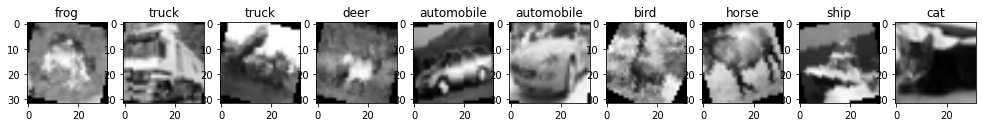

In [5]:
import matplotlib.pyplot as plt

N_IMAGES = 10

fig, ax = plt.subplots(1, N_IMAGES, figsize=(17,7))

for i in range(N_IMAGES):
    im, lbl = train_full[i]

    ax[i].imshow(im[0,:,:], 'gray', interpolation='bilinear')
    ax[i].set_title(f'{classes[lbl]}')

In [6]:
device = torch.device("cpu")
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        self.layer1 = self.ConvModule(in_features=3, out_features=64)      #16,16
        self.layer2 = self.ConvModule(in_features=64, out_features=128)    #8,8
        self.layer3 = self.ConvModule(in_features=128, out_features=256)   #4,4
        self.layer4 = self.ConvModule(in_features=256, out_features=512)   #2,2

        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(2*2*512, 1024),
                                        nn.ReLU(),
                                        nn.Linear(1024, 512),
                                        nn.ReLU(),
                                        nn.Linear(512,10),
                                        nn.Softmax())

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.classifier(x)
        return x

    def ConvModule(self, in_features, out_features):
        return nn.Sequential(nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=3, padding=1),
                            nn.BatchNorm2d(out_features),
                            nn.ReLU(),
                            nn.MaxPool2d(2,2)
                            )

model = CustomCNN().to(device)

In [7]:
torchsummary.summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             ReLU-11            [-1, 256, 8, 8]               0
        MaxPool2d-12            [-1, 256, 4, 4]               0
           Conv2d-13            [-1, 512, 4, 4]       1,180,160
      BatchNorm2d-14            [-1, 51

C:\Users\Matthew\anaconda3\lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [8]:
learning_rate = 0.001
num_epochs = 35
criterion = nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
import time
losses_per_iter = []

iteration = 0
#current_image_data = None


gt_labels = []
pred_labels = []
image_data_list = []

mutex = threading.Lock()


loss_available = threading.Condition(mutex)

class TrainModelService(TrainModelServicer):
    def TrainModel(self, request, context):
        # Simulate sending loss response for the iteration requested
        global iteration
        

        
            # Once a loss is available, increment the iteration and pop the first loss from the list
        iteration += 1
        cur_iteration = iteration
        loss = losses_per_iter.pop(0)
        
        
        
        response = LossResponse(iteration=cur_iteration, loss=loss) 
        return response
        
class ImageLabelService(ImageLabelServiceServicer):
    def GetImagePrediction(self, request, context):
        # Simulate getting image data, ground truth label, and prediction label
        # Replace these lines with your actual image processing and prediction logic
        # Assuming inputs, labels, and preds are global variables holding the current iteration's data
       
        global gt, pred, current_image_data
        global mutex
        
      
        
      
        
        # Get ground truth label and prediction label
        #with mutex:
        if gt_labels and pred_labels and image_data_list:
            gt_label = gt_labels.pop(0)
            pred_label = pred_labels.pop(0)
            current_image_data = image_data_list.pop(0)
            
        #gt_label = gt
        #pred_label = pred
    
    
            
            # Create and return the ImageLabelResponse
        response = ImageLabelResponse(
            iteration=request.iteration,
            image_data=current_image_data,
            ground_truth_label=gt_label,
            prediction_label=pred_label
        )
        return response
            
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    test_acc_history = []
    test_loss_history = []
    train_acc_history = []
    train_loss_history = []
    
    class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
    ]

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        #BELOW, original is ['train', 'test']
        for phase in ['train']:
            if phase == 'train':
                model.train()  # training mode
            else:
                model.eval()   # evaluate mode

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
              
                #print(labels)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    #print('outputs:', outputs)

                    _, preds = torch.max(outputs, 1)
                    
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                #convert all images in batch to bytes
                #print('preds', preds)
                if phase == 'train':
                    for i in range(len(inputs)):
                        global gt, pred, current_image_data
                        global mutex
                        
                        
                        img_byte_arr = BytesIO()
                        img = ToPILImage()(inputs[i])
                        
                        #resize image because it is small
                        img = img.resize((img.width * 2, img.height * 2), Image.BILINEAR)
                        img.save(img_byte_arr, format='JPEG')
    
                        #current_image_data = img_byte_arr.getvalue()
                        
                        #get ground truth label
                        gt_label = class_names[labels[i].item()]
                        pred_label = class_names[preds[i].item()]
    
                        #with mutex:
                        #print('ground truth:', gt_label)
                        #print('prediction:', pred_label)
                            #gt = gt_label
                            #pred = pred_label
                        gt_labels.append(gt_label)
                        pred_labels.append(pred_label)
                        image_data_list.append(img_byte_arr.getvalue())
                            
                    
                   
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += len(inputs)
            
                #only track training loss
                if phase == 'train':
                    losses_per_iter.append(loss.item())

                # Print training loss per iteration
                if phase == 'train':
                    print(f'Epoch [{epoch+1}/{num_epochs}], Iteration [{batch_idx+1}/{len(dataloaders[phase])}], Loss: {loss.item():.4f}')

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'test':
                test_acc_history.append(epoch_acc.cpu().numpy())
                test_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc.cpu().numpy())
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    history_dict = {'train_loss':train_loss_history, 'train_accuracy':train_acc_history,
                    'test_loss':test_loss_history, 'test_accuracy':test_acc_history}
    return model, history_dict
def start_grpc_server():
    server = grpc.server(futures.ThreadPoolExecutor(max_workers=10))
    add_TrainModelServicer_to_server(TrainModelService(), server)
    add_ImageLabelServiceServicer_to_server(ImageLabelService(), server)
    
    server.add_insecure_port('[::]:50051')
    server.start()
    print("gRPC Server started on port 50051.")
    try:
        while True:
            time.sleep(300)  # One day in seconds
    except KeyboardInterrupt:
        server.stop(0)

grpc_server_thread = threading.Thread(target=start_grpc_server)
grpc_server_thread.start()
trained_model, history_dict = train_model(model, dataloaders, criterion, optimizer, num_epochs)

Epoch 1/35
gRPC Server started on port 50051.
Epoch [1/35], Iteration [1/313], Loss: 2.3037
Epoch [1/35], Iteration [2/313], Loss: 2.3051
Epoch [1/35], Iteration [3/313], Loss: 2.3030
Epoch [1/35], Iteration [4/313], Loss: 2.3023
Epoch [1/35], Iteration [5/313], Loss: 2.3010
Epoch [1/35], Iteration [6/313], Loss: 2.3025
Epoch [1/35], Iteration [7/313], Loss: 2.2986
Epoch [1/35], Iteration [8/313], Loss: 2.3006
Epoch [1/35], Iteration [9/313], Loss: 2.3047
Epoch [1/35], Iteration [10/313], Loss: 2.3021
Epoch [1/35], Iteration [11/313], Loss: 2.3033
Epoch [1/35], Iteration [12/313], Loss: 2.2992
Epoch [1/35], Iteration [13/313], Loss: 2.3025
Epoch [1/35], Iteration [14/313], Loss: 2.3027
Epoch [1/35], Iteration [15/313], Loss: 2.3076
Epoch [1/35], Iteration [16/313], Loss: 2.3019
Epoch [1/35], Iteration [17/313], Loss: 2.2997
Epoch [1/35], Iteration [18/313], Loss: 2.3052
Epoch [1/35], Iteration [19/313], Loss: 2.3062
Epoch [1/35], Iteration [20/313], Loss: 2.3020
Epoch [1/35], Iteration

In [ ]:



# Call the train_model function
